In [1]:
# conda create -n depths
# mamba install -n depths -c conda-forge Jupyter pandas numpy scipy matplotlib

# First use scrape.js to get the post URLs and datetimes
# pd.read_json('./data/data.json').T.to_csv('./data/data.csv')
# And then open it in excel to manually annotate


In [2]:
import pandas as pd
import numpy as np
from urllib.parse import quote
import matplotlib.pyplot as plt
import datetime
import requests
import os
import time
import sqlite3
import scipy

class DB():
    def __init__(self, db_path='./data/db.sql'):
        self.db_path = db_path

        with sqlite3.connect(self.db_path) as con:
                cur = con.cursor()
                cur.execute('CREATE TABLE IF NOT EXISTS '
                            'pageviews(article, ig_post, rel_date, date, views)')
                con.commit()

        if not os.path.isfile(self.db_path):
            print(f'Created db at {self.db_path}')
        else:
            print(f'Database at {self.db_path} already exists.')
        
    def save_to_db(self, df):
        data = []
        for _, row in df.iterrows():
            data.append((row.Article, # Shut up I don't care if it's redundant
                        row.IG_post, 
                        row.Rel_Date, 
                        row.Date, 
                        row.Views))
        with sqlite3.connect(self.db_path) as con:
            cur = con.cursor()
            cur.executemany("INSERT INTO pageviews VALUES(?, ?, ?, ?, ?)", data)
            con.commit()
        print(f'Successfully saved data for article {data[0][0]}')

    def article_in_db(self, article):
        with sqlite3.connect(self.db_path) as con:
            cur = con.cursor()
            qry = 'SELECT COUNT(*) FROM pageviews WHERE article = ?'
            cur.execute(qry, (article,))
            count = cur.fetchone()[0]
        return count > 0
    
    def read_from_db(self):
        with sqlite3.connect(self.db_path) as con:
            cur = con.cursor()
            qry = 'SELECT article, ig_post, rel_date, date, views FROM pageviews'
            cur.execute(qry)
            res = cur.fetchall()

        out = pd.DataFrame(res)
        out.columns = ['Article', 'IG_post', 'Rel_Date', 'Date', 'Views']
        return out

def title_to_wikipedia_enc(title):
    encoded_title = quote(title.replace(' ', '_'), safe='')
    return encoded_title

def fill_missing_values(df, day_0):
    min_rel_date = df['Rel_Date'].min()
    max_rel_date = df['Rel_Date'].max()

    all_rel_dates = list(range(min_rel_date, max_rel_date + 1))
    if all(rd in df.Rel_Date for rd in all_rel_dates):  # Do nothing if df is complete
        return df
    else:
        complete_rel_dates = pd.DataFrame({'Rel_Date': all_rel_dates})
        complete_rel_dates['Article'] = df.Article[0]
        complete_rel_dates['IG_post'] = df.IG_post[0]
        complete_rel_dates['Date'] = ((day_0 + 
                                       pd.to_timedelta(complete_rel_dates['Rel_Date'], unit='D'))
                                       .dt.strftime('%Y-%m-%d'))
        
        view_values = df[['Date', 'Views']]
        res = pd.merge(complete_rel_dates, view_values, on='Date', how='left').fillna(0)
        res = res[['Article', 'IG_post', 'Rel_Date', 'Date', 'Views']]
        return res


def get_pageview_numbers(article, d0, ig_url, db, delta=31):
    article_enc = title_to_wikipedia_enc(article)

    day_0 = datetime.datetime.strptime(d0, '%m/%d/%Y')
    api_date_format = '%Y%m%d'
    day_start = (day_0 + datetime.timedelta(days=-delta)).strftime(api_date_format)
    day_end = (day_0 + datetime.timedelta(days=delta)).strftime(api_date_format)

    url = (f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article'
           f'/en.wikipedia/all-access/all-agents/'
           f'{article_enc}/daily/{day_start}00/{day_end}00')
    print(url)  # I will never apologize for print logging/debugging
    
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        pageviews_data = response.json()

        dates = []
        rel_dates = []
        views = []
        for item in pageviews_data['items']:
            cur_day = datetime.datetime.strptime(item['timestamp'], 
                                                  '%Y%m%d%S')
            rel_date = (cur_day - day_0).days

            cur_day_fmt = cur_day.strftime('%Y-%m-%d')
            cur_views = int(item['views'])
            
            dates.append(cur_day_fmt)
            rel_dates.append(rel_date)
            views.append(cur_views)

        out = pd.DataFrame({'Article': [article] * len(dates), 
                            'IG_post': [ig_url] * len(dates),
                            'Rel_Date': rel_dates,
                            'Date': dates, 
                            'Views': views})
        
        out = fill_missing_values(out, day_0)
        db.save_to_db(out)
    else:
        print(f'Error for article {article}: {response.status_code}')
        out = pd.DataFrame({'Article': [], 
                            'IG_post': [],
                            'Rel_Date': [],
                            'Date': [], 
                            'Views': []})
    
    return out


# data2.csv has the manual annotation and can't get overwritten by accident
data = pd.read_csv('./data/data2.csv').dropna()
data.columns = ['ig_index', 'ig_url', 'date', 'title']



In [5]:
my_db = DB()

for i, row in data.iterrows():
    if my_db.article_in_db(row.title):
        print(f'Skipping: {row.title}')
        next
    else:
        print(f'Scraping: {row.title}')
        try:
            get_pageview_numbers(article=row.title, d0=row.date, 
                                    ig_url=row.ig_url, db=my_db, delta=31)
        except ConnectionError as e:
            print(f'Failed: {row.title}')
        time.sleep(3)
        
        
################################################################################
# Load results from db
full_results = pd.DataFrame(my_db.read_from_db())

pd.options.mode.chained_assignment = None  # Remove all the warning messages
subsets = []
for article in full_results.Article.unique():
    subset = full_results[full_results.Article == article]
    try:
        reference_point = int(subset[subset.Rel_Date == -1].Views)
        rel_views = subset['Views'] / reference_point
        subset.loc[:, 'Rel_Views'] = rel_views

        subsets.append(subset)

        # ax.plot(subset.Rel_Date, subset.Rel_Views, alpha=0.3, c='black')
    except TypeError:
        print(f'Not working for article: {article}')
        
        
################################################################################   
# Aggregation

# https://stackoverflow.com/a/17578653/15014819
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'p{:02.0f}'.format(n*100)
    return percentile_

combined = pd.concat(subsets)
aggfuns = ['mean', 'std', 
           percentile(0.10),
           percentile(.25), 
           percentile(.50), 
           percentile(.75),
           percentile(0.90)]
summary = (combined.replace([np.inf, -np.inf], np.nan)
           .dropna().groupby('Rel_Date')
           .agg({'Rel_Views': aggfuns,
                 'Views': aggfuns}))



Database at ./data/db.sql already exists.
Skipping: Muphry's Law
Skipping: Lawrence Eagleburger
Skipping: Chicago rat hole
Skipping: 1967 NFL Championship Game
Skipping: List of sundial mottos
Skipping: Lal Bihari
Skipping: Sergei Krikalev
Skipping: Prophetic perfect tense
Skipping: Ship of Theseus
Skipping: User:Asticky
Skipping: Berners Street hoax
Skipping: Hagia Sophia
Skipping: Tootsie Roll
Skipping: Headfooters
Skipping: Mao Zedong
Skipping: Yu-Mex
Skipping: Muhamed (horse)
Skipping: Elf
Skipping: Curse of the Colonel
Skipping: List of humorous units of measurement
Skipping: Museum of Bad Art
Skipping: The Emoji Movie
Skipping: Golf at the 1900 Summer Olympics
Skipping: List of television series canceled before airing an episode
Skipping: List of Generation Z slang
Skipping: Texas, New York
Skipping: New York, Texas
Skipping: James French (murderer)
Skipping: Greg Packer
Scraping: Category:Animals with paper party hats
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-artic

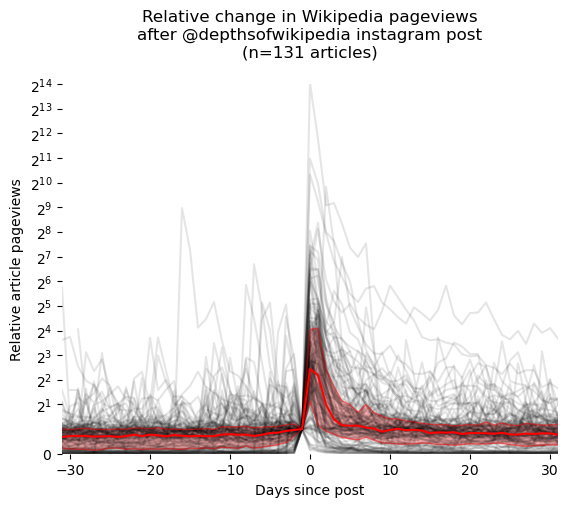

In [6]:
################################################################################
# Actual viz now

(fig, ax) = plt.subplots(1,1)
for article in combined.Article.unique():
    sub = combined[combined.Article == article]
    ax.plot(sub.Rel_Date, sub.Rel_Views, alpha=0.1, c='black')

# Plot trendline for mean
# avg = summary.Rel_Views['mean']
# ax.plot(summary.index, avg, c='green', lw=2, ls=':')

# Plot trendline for q25, q50, q75
ax.plot(summary.index, summary.Rel_Views['p50'], c='red', lw=1.5, 
        ls='-')
ax.plot(summary.index, summary.Rel_Views['p25'], c='red', lw=1, 
        ls='-', alpha=0.5)
ax.plot(summary.index, summary.Rel_Views['p75'], c='red', lw=1, 
        ls='-', alpha=0.5)
ax.fill_between(summary.index, 
                summary.Rel_Views['p25'], 
                summary.Rel_Views['p75'], 
                facecolor='red', alpha=0.3)

period = 31
ymin = 0
ymax = combined.replace([np.inf, -np.inf], np.nan).dropna().Rel_Views.max()
ax.set_xlim(-period, period)
ax.set_ylim(ymin, 2**14)
ax.set_yscale('symlog', base=2)
ax.set_xlabel('Days since post')
ax.set_ylabel('Relative article pageviews')
ax.set_title(f'Relative change in Wikipedia pageviews'
             f'\nafter @depthsofwikipedia instagram post'
             f'\n(n={combined.Article.unique().size} articles)', pad=20)
ax.set_frame_on(False)

fig.show()

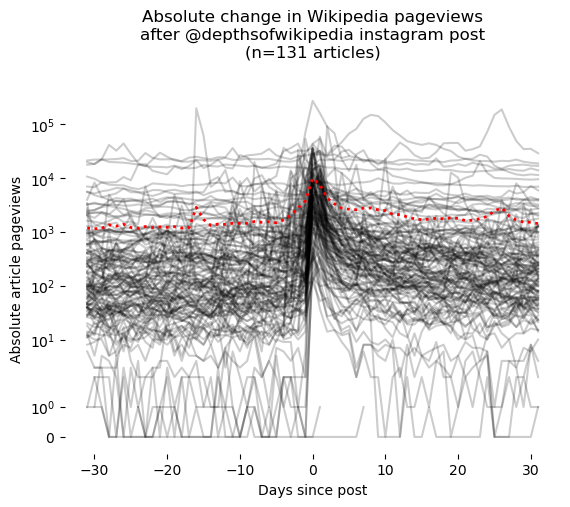

In [8]:
(fig, ax) = plt.subplots(1,1)

avg = summary.Views['mean']
sd = summary.Views['std']
lower = avg - sd
upper = avg + sd
ymin = 0
ymax = combined.replace([np.inf, -np.inf], np.nan).dropna().Rel_Views.max()

for article in combined.Article.unique():
    sub = combined[combined.Article == article]
    ax.plot(sub.Rel_Date, sub.Views, alpha=0.2, c='black')
ax.plot(summary.index, avg, c='red', lw=2, ls=':')
ax.set_yscale('symlog')
ax.set_frame_on(False)
ax.set_xlabel('Days since post')
ax.set_ylabel('Absolute article pageviews')
ax.set_title(f'Absolute change in Wikipedia pageviews'
             f'\nafter @depthsofwikipedia instagram post'
             f'\n(n={combined.Article.unique().size} articles)', pad=20)

fig.show()

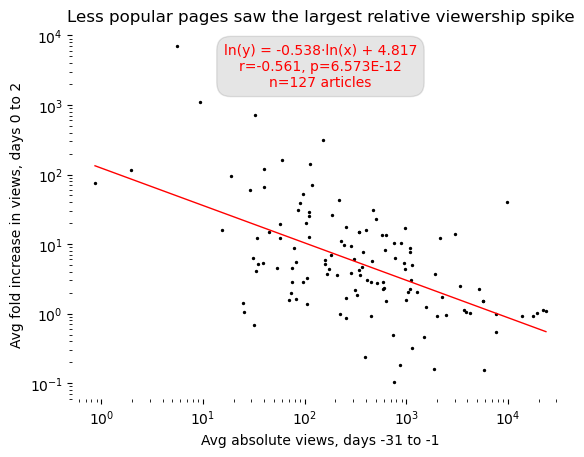

In [26]:
avg_before = (combined[combined.Rel_Date.between(-31, -1)]
              .groupby('Article')
              .agg({'Views': ['mean', 'std'], 
                    'Rel_Views': ['mean', 'std']}))
avg_peak = (combined[combined.Rel_Date.between(0,2)]
            .groupby('Article')
            .agg({'Views': ['mean', 'std'], 
                  'Rel_Views': ['mean', 'std']}))

assert all(avg_before.index == avg_peak.index)

# Regression line
valid_pages = avg_peak.index[~np.isnan(avg_peak.Rel_Views['mean']) & 
                             ~np.isinf(avg_peak.Rel_Views['mean'])]
res = scipy.stats.linregress(np.log(avg_before.loc[valid_pages,:].Views['mean']), 
                             np.log(avg_peak.loc[valid_pages,:].Rel_Views['mean']))
min_x = avg_before.loc[valid_pages,:].Views['mean'].min()
max_x = avg_before.loc[valid_pages,:].Views['mean'].max()

x_reg = np.arange(min_x, max_x, 1)
y_reg = np.exp(res.slope * np.log(x_reg) + res.intercept)
eqn = (f'ln(y) = {res.slope:.3f}·ln(x) + {res.intercept:.3f}'
       f'\nr={res.rvalue:.3f}, p={res.pvalue:.3E}'
       f'\nn={len(valid_pages)} articles' )


(fig, ax) = plt.subplots(1,1)
ax.scatter(avg_before.Views['mean'], avg_peak.Rel_Views['mean'], c='black', s=2)
ax.plot(x_reg, y_reg, c='red', ls='-', lw=1)
ax.text(0.5, 0.9, eqn, c='red', 
        transform = ax.transAxes, 
        horizontalalignment='center',
        verticalalignment='center',
        bbox=dict(boxstyle='round, rounding_size=1, pad=0.5', 
                  facecolor='black', alpha=0.1))


ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlabel('Avg absolute views, days -31 to -1')
ax.set_ylabel('Avg fold increase in views, days 0 to 2')
ax.set_frame_on(False)
ax.set_title('Less popular pages saw the largest relative viewership spike')



fig.show()